In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pdpbox import pdp
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.stats import chi2_contingency

c:\Users\ibenn\Desktop\DSB\Year 2 HEC\Interpretable-jimams\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
raw_data = pd.read_csv("../data/data_clean.csv")

# Load the model from the .pkl file
xgb_classifier = pickle.load(open("..\model\model.pkl", "rb"))


In [23]:
def preprocess_data(raw_data):
    data = raw_data[raw_data['birth date'] < 2020].copy()
    data['age'] = data['parole board interview date'] - data['birth date']
    data['jail duration'] = data['parole board interview date'] - data['year of entry']
    others_parole_type =  ['PIE', 'SP CONSDR', 'ECPDO', 'MEDICAL','RESCISSION', 'DEPORT']
    data['parole board interview type'] = data['parole board interview type'].replace(others_parole_type, 'OTHERS').replace('SUPP MERIT', 'MERIT TIME').replace('PV REAPP', 'REAPPEAR')
    data = data.dropna(axis=0, subset=['crime 1 - class', 'parole eligibility date'])
    df_one_hot = pd.get_dummies(data, columns=[
        "sex", "race / ethnicity"], drop_first=True)
    df_one_hot = pd.get_dummies(df_one_hot, columns=[
        "crime 1 - class", "crime 2 - class",
        "crime 3 - class", "crime 4 - class",
        "parole board interview type"])
    df_one_hot.drop(columns=['release date','birth date', 'year of entry'], inplace=True)
    return df_one_hot

In [32]:
def replace_predict_chi_square(model, X, column, protected_column, value):
    X_copied = preprocess_data(X)
    unique_values = X[column].unique()
    if X[column].dtype in ['category', 'bool','object']:
        for unique_value in unique_values:
            
            if str(unique_value) != 'nan':
                X_copied[column + "_" + str(unique_value)] = (value == unique_value)
    else:
        print("hello")
        X_copied[column] = value

    print(X_copied.dtypes)
    y_pred = model.predict(X_copied)
    contingency_table = pd.crosstab(X.loc[X_copied.index][protected_column], y_pred)
    chi2, p, a, b = chi2_contingency(contingency_table)
    return p

In [30]:
def predict_chi_square(model, X, column, protected_column):
    if X[column].dtype == 'float64':
        values_final = np.linspace(X[column].min(), X[column].max(), 50)
    else:
        values = X[column].unique()
    p_values = []
    values_final = []
    for value in values:
        if not(str(value) == 'nan'):
            p_value = replace_predict_chi_square(model, X, column, protected_column, value)
            p_values.append(p_value)
            values_final.append(value)

    plt.figure()
    plt.plot(values_final, p_values)
    plt.show()

parole board interview date                 int64
parole eligibility date                   float64
min_sentence                              float64
max_sentence                              float64
count of crimes                             int64
age                                       float64
jail duration                               int64
sex_MALE                                     bool
race / ethnicity_ASIAN/PACIFIC               bool
race / ethnicity_BLACK                       bool
race / ethnicity_HISPANIC                    bool
race / ethnicity_OTHER                       bool
race / ethnicity_UNKNOWN                     bool
race / ethnicity_WHITE                       bool
crime 1 - class_A                            bool
crime 1 - class_B                            bool
crime 1 - class_C                            bool
crime 1 - class_D                            bool
crime 1 - class_E                            bool
crime 2 - class_A                            bool


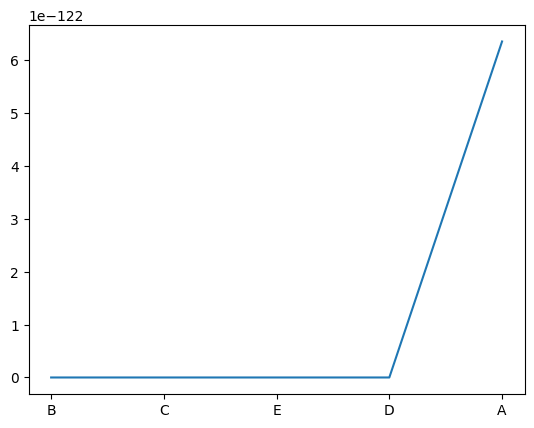

In [34]:
predict_chi_square(xgb_classifier, raw_data.drop('y', axis=1), "crime 1 - class", "sex")